# Temperature Analysis

In [194]:
import sys
import os
sys.path.append(os.path.abspath(".."))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from time_of_flight_calculation.tof import *
from time_of_flight_calculation.velocity import *
from time_of_flight_calculation.sugar_velocity_relationship import *
from time_of_flight_calculation.correlation import *
from plotting_module.crosscorrelation_plot import *


In [196]:
root_folder=r"/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/Temperature_analysis"

In [197]:
waveforms=["sin","squ"]
periods= ["1","5","9"]

expected_waveform= waveforms[1]
expected_periods= periods[2]

unique_file_list= findFiles(expected_waveform,expected_periods,root_folder,sample_number=1)
unique_file_list

['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/Temperature_analysis/50_degree/50degree_28thmaynewsetup1per-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/Temperature_analysis/40_degree/40degree_28thmaynewsetup1per-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/Temperature_analysis/35_degree/35degree_28thmaynewsetup1per-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/Temperature_analysis/25_degree/25degree_28thmaynewsetup1per-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  

## Processing

In [198]:
def LoadDataSignals(file_path,time_axis_start=0,time_axis_end=16000):    

    fs=125000000 # Sampling frequency in HZ

    #Extracting the values from file path


    actual_waveform=file_path.split("-")[-2]
    #Concentration=file_path.split("/")[-2]
    Concentration= file_path.split("-")[-3].strip("mg")

    periods=int(actual_waveform[-1])
    waveform=actual_waveform=file_path.split("-")[-2][0:3]
    temperature=file_path.split("/")[8][0:2]
    print("temperature",temperature)

    title=Concentration +" " +"("+actual_waveform +")"

    #Loading mat file data
    mat_data = loadmat(file_path)        
    raw = np.squeeze(mat_data['raw_data']) #remove single dimension [100,2,16000]

    # Raw transmit and receive signals
    #raw_transmit_signal=raw[0,0,time_axis_start:time_axis_end]
    #raw_receive_signal=raw[0,1,time_axis_start:time_axis_end]

    return raw,Concentration,waveform,periods,temperature

In [199]:

def process_signals(unique_file_list, tof_method_index=1, comp_index=3):
    velocities = []
    concentrations = []
    tofs = []
    file_paths = []
    transmit_selected_index_list = [] #peak to peak calc
    receive_selected_index_list = [] #peak to peak calc
    receive_selected_amplitude = []
    transmit_selected_amplitude = []
    first_echo_start = []
    first_echo_end = []
    refractometer_readings = [0,1,2,3,4,5,6,7,8,9,10,11]
    selected_index_list = []
    temperatures=[]

    tof_methods = ['peak_to_peak', 'zero_crossing', 'cross_correlation']
    selected_method = tof_methods[tof_method_index]
    print("Selected Method is: ", selected_method)

    start=0
    end=16000


    for file in unique_file_list:

        print("\n\n File Name:",file)
        raw,concentration,actual_waveform,periods,temperature=LoadDataSignals(file,time_axis_start=0,time_axis_end=16000)

        print("shape of raw signal: ",raw.shape)

        print("Period: ", periods)
        print("Concentration: ",concentration)

        # Dc offset removal
        transmit, receive= dc_offset_removal(raw)


        # Pan Tompkins Algorithm
        _receive = receive[0, start:end]
        _transmit = transmit[0, start:end]
        transmit_echo_list,recieve_echo_list,transmit_min_max_pairs,recieve_min_max_pairs=apply_pan_algorithm(_transmit,_receive,periods,T,low_cutoff, high_cutoff, order=4, window_size=11,min_prominence=0.05)

        # Zero Crossing
        
        # Get the first transmit echo pair
        transmit_max_pair = transmit_echo_list[0]
        t_start_index = transmit_max_pair[0]
        # Get the first recieve echo pair
        recieve_max_pair = recieve_echo_list[0]
        r_start_index = recieve_max_pair[0]






        if selected_method == 'zero_crossing':
            #transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(raw[:,0,:],receive,threshold=500000)

            """#using time synchronized signal
            transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(raw[:,0,:],receive,threshold=500000)
            transmit_zero_pair = find_next_zero_crossings(transmit_averaged_signal[0], [t_start_index])
            receive_zero_pair = find_next_zero_crossings(recieve_averaged_signal[0], [r_start_index])"""
        
            """#using bandpass filter
            bandpassed_transmit = apply_bandpass_filter(transmit[0, start:end], fs, 1e6, 6.5e6)
            bandpassed_receive = apply_bandpass_filter(receive[0, start:end], fs, 1e6, 6.5e6)
            transmit_zero_pair = find_next_zero_crossings(bandpassed_transmit, [t_start_index])
            receive_zero_pair = find_next_zero_crossings(bandpassed_receive, [r_start_index])"""
            

            transmit_filtered_hanning = batch_apply_hanning_filter(transmit)
            recieve_filtered_hanning = batch_apply_hanning_filter(receive)

            #transmit_filtered_derivative=apply_improved_derivative_filter(transmit, T=T)
            #eceive_filtered_derivative=apply_improved_derivative_filter(receive, T=T)

            # using dc offset removed orignal signals

            transmit_zero_pair = find_next_zero_crossings(transmit_filtered_hanning[0,:], [t_start_index])
            receive_zero_pair = find_next_zero_crossings(recieve_filtered_hanning[0,:], [r_start_index])

            tof = findTOF(transmit_zero_pair, receive_zero_pair) 
        

        if selected_method == 'cross_correlation':
    
            #transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(raw[:,0,:],receive,threshold=500000)
            #bandpassed_transmit = apply_bandpass_filter(transmit_averaged_signal[0], fs, 12e6, 18e6)
            #bandpassed_receive = apply_bandpass_filter(recieve_averaged_signal[0], fs, 12e6, 18e6)

            bandpassed_transmit = apply_bandpass_filter(transmit[0, start:end], fs, 3e6, 7e6)
            bandpassed_receive = apply_bandpass_filter(receive[0, start:end], fs, 3e6, 7e6)

            transmit_filtered_derivative=apply_improved_derivative_filter(transmit, T=T)
            receive_filtered_derivative=apply_improved_derivative_filter(receive, T=T)


            
            #tof, sample_delay, corr = calculate_tof_cross_correlation(bandpassed_transmit[:3000], bandpassed_receive[6000:], fs=125e6)

            try:
                tof, delay_samples, corr, lags = calculate_windowed_tof_cross_correlation(
                    bandpassed_transmit, bandpassed_receive,
                    t_start_index, r_start_index-100,
                    fs=125e6, window_size=600
                )
                print("TOF calculated:", tof)
                plot_windowed_cross_correlation(corr, lags, tof)
            except Exception as e:
                print(f"[ERROR] Cross-correlation TOF calculation failed: {e}")
                continue  # skip to next file

            #plot_cross_correlation(bandpassed_transmit[:3000], bandpassed_receive[6000:], corr, sample_delay, fs, concentration, actual_waveform, receive_start_index=6000)





        tofs.append(tof)
        temperatures.append(temperature)
        velocity = find_Velocity(tof, distance = 0.083)
        velocities.append(velocity)
        concentrations.append(int(concentration))
        print("Velocity: ", velocity)

    zipped_data = list(zip(concentrations,velocities))
    temperature_data = list(zip(concentrations,velocities,tofs,temperatures))

    converted_velocity = convert_mg_to_percent(zipped_data, water_quantity)
    time_of_flight = list(zip(concentrations,tofs))
    receive_selected_index_list = list(zip(concentrations,file_paths,receive_selected_index_list,receive_selected_amplitude))
    transmit_selected_index_list = list(zip(concentrations,file_paths,transmit_selected_index_list,transmit_selected_amplitude))

    print("Selectd Index", receive_selected_index_list)




    return temperature_data,converted_velocity,time_of_flight,actual_waveform,receive_selected_index_list,transmit_selected_index_list #min(first_echo_start),max(first_echo_end)



In [200]:
def plot_temperature_vs_velocity(data):
    temperatures = [int(temp) for _, _, _, temp in data]
    velocities = [vel for _, vel, _, _ in data]

    plt.figure(figsize=(8, 5))
    plt.plot(temperatures, velocities, marker='o', linestyle='-', color='blue')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Velocity (m/s)")
    plt.title("Velocity vs Temperature at 0 mg Sugar")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_temperature_vs_tof(data):
    temperatures = [int(temp) for _, _, _, temp in data]
    tofs_ns = [tof * 1e9 for _, _, tof, _ in data]  # convert to ns for better readability

    plt.figure(figsize=(8, 5))
    plt.plot(temperatures, tofs_ns, marker='s', linestyle='-', color='orange')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Time-of-Flight (ns)")
    plt.title("ToF vs Temperature at 0 mg Sugar")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_temperature_vs_tof(data):
    temperatures = [int(temp) for _, _, _, temp in data]
    tofs_ns = [tof * 1e9 for _, _, tof, _ in data]  # convert to ns for better readability

    plt.figure(figsize=(8, 5))
    plt.plot(temperatures, tofs_ns, marker='s', linestyle='-', color='orange')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Time-of-Flight (ns)")
    plt.title("ToF vs Temperature at 0 mg Sugar")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




# Time of flight using Zero Crossing

In [201]:
tof_methods = ['peak_to_peak', 'zero_crossing', 'cross_correlation']


In [202]:
temperature_data,velocities,time_of_flight,actual_waveform,receive_selected_index_list,transmit_selected_index_list =process_signals(unique_file_list, tof_method_index=1)

Selected Method is:  zero_crossing


 File Name: /Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/Temperature_analysis/50_degree/50degree_28thmaynewsetup1per-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat
temperature 50
shape of raw signal:  (100, 2, 16000)
Period:  9
Concentration:  0
DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)
Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(2, 212)]
Recieve [(6077, 8863)]
extrema_indices:  [2]
Signal at index 2: -293063.75 (sign: -1.0)
Signal slice after index 2: [-277504.75 -400877.   -519159.25 -495486.5  -484947.5  -503994.75
 -512561.5 ]
extrema_index: 2 type: <class 'int'>
extrema_indices:  [6077]
Signal at index 2: -2395.362548828125 (sign: -1.0)
Signal slice after index 2: [ -77300.36230469 -122584.11328125 -250185.86523438 -482358.87109375
 -595482.875      -542365.125  

In [203]:
temperature_data = sorted(temperature_data, key=lambda x : x[3])
temperature_data

[(0, 1672.9689905047144, 4.961239596853491e-05, '25'),
 (0, 1685.2594557656514, 4.9250576649214664e-05, '30'),
 (0, 1693.677104736496, 4.900579913838608e-05, '35'),
 (0, 1703.676841604316, 4.8718159437937e-05, '40'),
 (0, 1708.485172387943, 4.858104790221341e-05, '45'),
 (0, 1709.9966784486207, 4.853810597766834e-05, '50')]

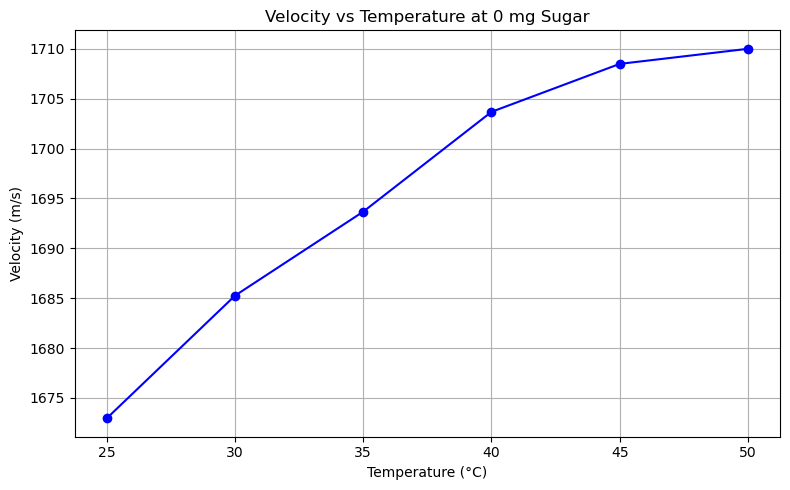

In [204]:
plot_temperature_vs_velocity(temperature_data)

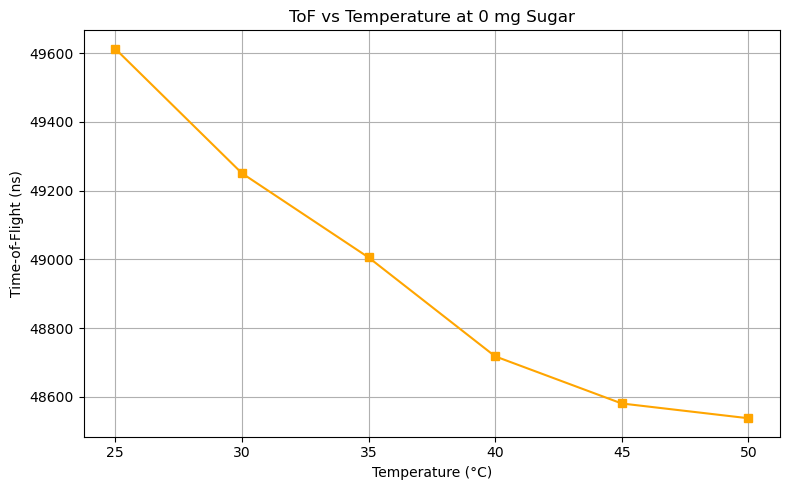

In [205]:
plot_temperature_vs_tof(temperature_data)